CELL SEGMENTATION USING U-NET

Benefits of Using U-Net for Cell Segmentation

High Accuracy: U-Net's skip connections preserve high-resolution features, leading to precise segmentation boundaries.
Scalability: The architecture can handle 2D and 3D biomedical images.
As a widely adopted model, U-Net has numerous extensions and enhancements that can be integrated based on task requirements.

In [1]:
!curl -H "GET /?list-type=2 HTTP/1.1" \
     -H "Host: livecell-dataset.s3.eu-central-1.amazonaws.com" \
     -H "Date: 20161025T124500Z" \
     -H "Content-Type: text/plain" http://livecell-dataset.s3.eu-central-1.amazonaws.com/ > files.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25149    0 25149    0     0  44643      0 --:--:-- --:--:-- --:--:-- 44590


In [2]:
!grep -oPm1 "(?<=<Key>)[^<]+" files.xml | sed -e 's/^/http:\/\/livecell-dataset.s3.eu-central-1.amazonaws.com\//' > urls.txt

**DOWNLOAD THE IMAGES**

In [3]:
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip

--2024-11-17 18:16:42--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.140.53, 3.5.135.150, 52.219.75.100, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.140.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241715651 (1.2G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   1.16G  25.5MB/s    in 49s     

2024-11-17 18:17:32 (24.1 MB/s) - ‘images.zip’ saved [1241715651/1241715651]



In [4]:
!mkdir Dataset

In [5]:
!unzip -qq /content/images.zip -d /content/Dataset

In [6]:
!mkdir /content/Dataset/annotations

In [7]:
%cd /content/Dataset/annotations

/content/Dataset/annotations


Download the JSON files containing annotations

In [8]:
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json

--2024-11-17 18:17:47--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.135.126, 3.5.137.201, 3.5.137.200, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|3.5.135.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260794837 (249M) [application/json]
Saving to: ‘livecell_coco_test.json’

livecell_coco_test. 100%[===================>] 248.71M  14.2MB/s    in 15s     

2024-11-17 18:18:02 (16.5 MB/s) - ‘livecell_coco_test.json’ saved [260794837/260794837]

--2024-11-17 18:18:02--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.135

We need the input images and the annotations to be drawn on the input images.
The below code separates the images into sets such as train, val and test. It outputs the masks in separate sets as well for training purpose

In [9]:
import os
import cv2
import json
import shutil
import numpy as np

image_dir = "/content/Dataset/images"
annotations_dir = "/content/Dataset/annotations"
output_masks_dir = "/content/Dataset/masks"

# Mapping annotation files to their respective output folders
annotation_to_output_folder = {
    "livecell_coco_train.json": "train",
    "livecell_coco_val.json": "val",
    "livecell_coco_test.json": "test",
}

# Paths to the directories
train_val_dir = os.path.join(image_dir, "livecell_train_val_images")
test_dir = os.path.join(image_dir, "livecell_test_images")

# Create the output directories
os.makedirs(output_masks_dir, exist_ok=True)
for folder in annotation_to_output_folder.values():
    os.makedirs(os.path.join(output_masks_dir, folder), exist_ok=True)

# Create separate input image directories
train_folder = os.path.join(image_dir, "livecell_train_images")
val_folder = os.path.join(image_dir, "livecell_val_images")
test_folder = os.path.join(image_dir, "livecell_test_images")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
#os.makedirs(test_folder, exist_ok=True)

# Function to create a binary mask
def create_binary_mask(image_shape, segmentations):
    # Initialize a blank binary mask
    mask = np.zeros(image_shape, dtype=np.uint8)
    for segmentation in segmentations:
        # Convert the segmentation coordinates to a polygon
        points = np.array(segmentation, dtype=np.int32).reshape((-1, 1, 2))
        # Fill the polygon on the mask
        cv2.fillPoly(mask, [points], color=1)  # White pixels for the mask
    return mask

# Process each annotation file
for annotation_file, output_folder in annotation_to_output_folder.items():
    json_path = os.path.join(annotations_dir, annotation_file)
    with open(json_path, "r") as file:
        data = json.load(file)

    # Determine input subfolder based on annotation type
    if annotation_file in ["livecell_coco_train.json", "livecell_coco_val.json"]:
        input_dir = train_val_dir
        target_folder = train_folder if annotation_file == "livecell_coco_train.json" else val_folder
    else:
        input_dir = test_dir
        target_folder = test_folder

    # Map image ID to image metadata
    image_info = {img['id']: img for img in data['images']}

    # Organize annotations by image ID
    annotations = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations:
            annotations[img_id] = []
        annotations[img_id].append(ann['segmentation'])

    # Process each image in the annotations
    for img_id, seg_list in annotations.items():
        if img_id not in image_info:
            print(f"Warning: Image ID {img_id} not found in image metadata.")
            continue

        img_metadata = image_info[img_id]
        img_path = os.path.join(input_dir, img_metadata['file_name'])

        # Handle different extensions
        if not os.path.exists(img_path):
            img_path = img_path.replace(".tif", ".png")
        if not os.path.exists(img_path):
            print(f"Warning: Image not found for ID {img_id} at {img_path}. Skipping...")
            continue

        # Move the image to its respective folder (train, val, or test)
        target_path = os.path.join(target_folder, img_metadata['file_name'])
        if not os.path.exists(target_path):
            shutil.copy(img_path, target_path)

        # Read the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image at {img_path}. Skipping...")
            continue

        # Create a binary mask with the same height and width as the image
        binary_mask = create_binary_mask((img.shape[0], img.shape[1]), seg_list)

        # Save the binary mask in the appropriate output subfolder
        output_path = os.path.join(output_masks_dir, output_folder, img_metadata['file_name'])
        cv2.imwrite(output_path, binary_mask)

print("Masks applied, input images separated, and outputs saved!")

Masks applied, input images separated, and outputs saved!


As we are using UNET, need to install segmentation-models-pytorch and also install lightning as we are using pytorch lightning

In [10]:
!pip install -q torchmetrics segmentation-models-pytorch lightning

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.8 MB/s eta 0:00:00


In [11]:
%cd /content

/content


Create a custom DataLoader called SegmentDataset

In [12]:
import os
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

class SegmentDataset(Dataset):
    def __init__(self, dirPath=r'/content/Dataset', imageDir='images/livecell_train_images', masksDir='masks/train', train=True):
        self.train = train
        self.imgDirPath = os.path.join(dirPath, imageDir)
        self.nameImgFile = sorted([f for f in os.listdir(self.imgDirPath) if f.endswith('.tif')])

        if train:
            self.maskDirPath = os.path.join(dirPath, masksDir)
            self.nameMaskFile = sorted([f for f in os.listdir(self.maskDirPath) if f.endswith('.tif')])

    def __len__(self):
        return len(self.nameImgFile)

    def __getitem__(self, index):
        imgPath = os.path.join(self.imgDirPath, self.nameImgFile[index])
        img = cv2.imread(imgPath, cv2.IMREAD_COLOR)
        width = img.shape[0]
        height = img.shape[1]

        train_transform = A.Compose(
            [
                A.Resize(1024, 1024),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])

        if self.train:
            maskPath = os.path.join(self.maskDirPath, self.nameMaskFile[index])
            mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE) # Read mask as greyscale
        else:
            mask = img

        dt = train_transform(image=img, mask=mask)
        return dt['image'], dt['mask'], width, height, self.nameImgFile[index]

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [13]:
from torch.utils.data import DataLoader

def get_train_val_data(dirPath=r'/content/Dataset', batch_size=4):

    trainData = SegmentDataset(dirPath = dirPath)
    valData = SegmentDataset(dirPath = dirPath, imageDir='images/livecell_val_images', masksDir='masks/val')

    train_dl = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dl = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_dl, val_dl

Visualize the input image and the masks

In [14]:
train_dl, val_dl = get_train_val_data(batch_size=4)

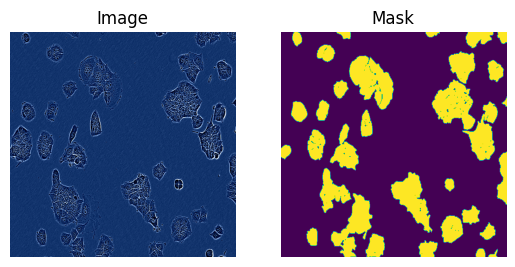

In [15]:
import matplotlib.pyplot as plt
import numpy as np

i = next(iter(train_dl))
img , mask, width, height, fileName = i
plt.subplot(1,2,1)
plt.imshow(img[0].permute(1,2,0).numpy())
plt.title('Image')
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask[0])
plt.title('Mask')
plt.axis(False)
plt.show()

Below is the Segmentation Model from segmentation_models_pytorch

In [16]:
import torch
from torch import nn
from torchmetrics.classification import Dice
import pytorch_lightning as pl
from torch.optim import lr_scheduler
from torch.utils.data import Subset, DataLoader
import segmentation_models_pytorch as smp
import argparse

class CellSegmentation(pl.LightningModule):

    def __init__(self, encoder_name, in_channels, out_classes, T_MAX, **kwargs):
        super().__init__()
        self.T_MAX = T_MAX
        self.out_classes = out_classes
        self.model = smp.Unet(
            encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        self.dice_metric = Dice(num_classes=out_classes, threshold=0.7)
        self.criterion = nn.CrossEntropyLoss()

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        self.save_hyperparameters()

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask, _, _, _ = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        logits_mask = self.forward(image)

        loss_ce = self.criterion(logits_mask, mask.long())

        prob_mask = logits_mask.argmax(axis=1)

        dice_metric = self.dice_metric(prob_mask, mask)

        self.log(f"{stage}_loss", loss_ce, prog_bar=True)
        self.log(f"{stage}_dice", dice_metric, prog_bar=True)

        return {
            "loss": loss_ce,
            "dice_metric": dice_metric,
        }

    def shared_epoch_end(self, outputs, stage):
        pass

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, amsgrad=True)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.T_MAX, eta_min=1e-5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step',
                'frequency': 1,
            },
        }
        return

    def configure_callbacks(self):
        early_stop = pl.callbacks.EarlyStopping(monitor="valid_loss", mode="min", min_delta=0.001, patience=5)
        checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid_loss", filename='{epoch}-{valid_loss:.3f}')
        return [early_stop, checkpoint]

Mention the parameters for training such as directory path, epochs, model saving path

In [17]:
parser = argparse.ArgumentParser(description = 'Segmentation training')
parser.add_argument('--dirPath', default='/content/Dataset', help='Parent directory of training dataset')
parser.add_argument('--epochs', default=1, type=int, help='Number of training epochs')
parser.add_argument('--pretrained_model_name', default='resnet34', help='Pretrained encoder model name')
parser.add_argument('--model_save_path', default='/content/trained_model', help='Path to save trained model')
args = parser.parse_args([])

Training code


In [18]:
# Some training hyperparameters
EPOCHS = args.epochs
OUT_CLASSES = 2

train_dl, val_dl = get_train_val_data(dirPath=args.dirPath)
T_MAX = EPOCHS * len(train_dl)

model = CellSegmentation(args.pretrained_model_name, in_channels=3, out_classes=OUT_CLASSES, activation='sigmoid', T_MAX=T_MAX)

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 142MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | model       | Unet             | 24.4 M | train
1 | dice_metric | Dice             | 0      | train
2 | criterion   | CrossEntropyLoss | 0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Once training is complete, save the best model in the mentioned directory

In [19]:
del model

In [20]:
best_model = CellSegmentation.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    encoder_name=args.pretrained_model_name,
    in_channels=3,
    out_classes=OUT_CLASSES,
    activation='sigmoid',
    T_MAX=T_MAX
    )

best_model.model.save_pretrained(args.model_save_path)
print(f"Best model saved at {args.model_save_path}")

Best model saved at /content/trained_model
